In [8]:
#this is a testing file for various aspects of the project research
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt

In [12]:
def testBaseline(df, threshold): 
   
    df['alarm'] = df['rolling_std'] > threshold

    #get flags (only alarms where they are the first occurence in a group of alarms)
    flags = pd.Series(False, index=df.index)
    for i in range(1, len(df['alarm'])):
        flags.iloc[i] = df['alarm'].iloc[i] and not df['alarm'].iloc[i-1]
    df['flags'] = flags

    #get false alarms (defined as: flags where the vol drops below 80% of threshold within next 30 min)
    falseAlarms = pd.Series(False, index = df.index)
    for i in range(1,len(df['alarm']) - 30):
        if df['flags'].iloc[i]:
            isFalse = False #isFalse will be true for false alarms
            for j in range(30):
                if  (i + j) < len(df['rolling_std']):
                    if df['rolling_std'].iloc[i+j] < 0.8*threshold:
                        isFalse = True
                        break
            falseAlarms.iloc[i] = isFalse
        else: falseAlarms.iloc[i] = False
    df['falseAlarm'] = falseAlarms
    alarmRate = df['alarm'].sum()/len(df['alarm'])
    return df['falseAlarm'].sum()/df['flags'].sum() if (df['flags'].sum() != 0) else 0


minimum FAR 0.043478260869565216
minimum FAR 0.05263157894736842
minimum FAR 0.1111111111111111
minimum FAR 0.0625


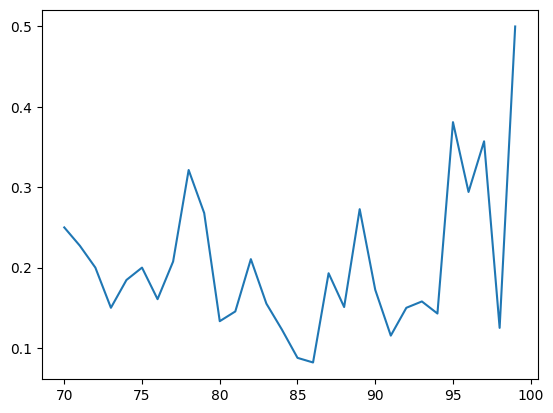

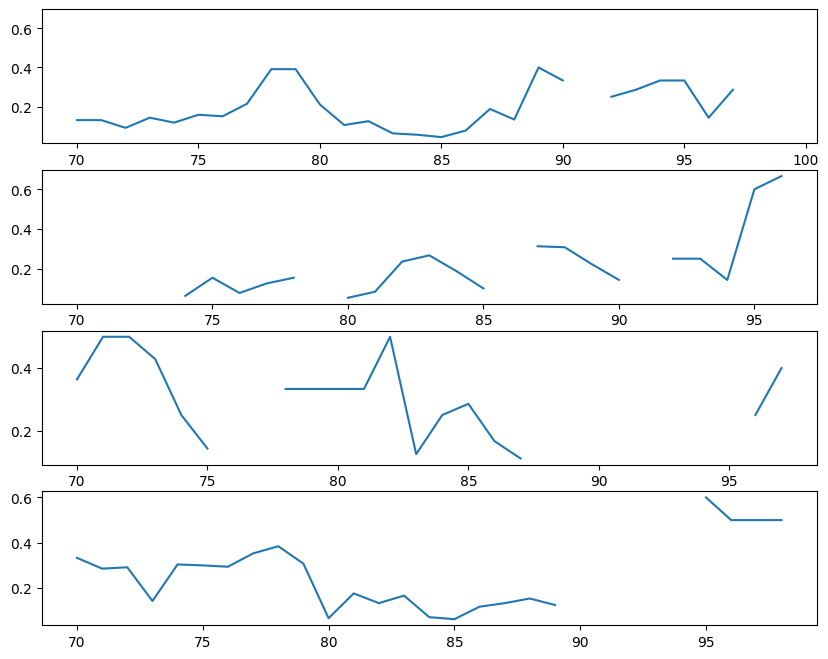

In [25]:
#script to test various threshold values and identify false alarms
# Loading data from CSV (SPY_Datafull.csv)
dataPath = r"C:\Users\samps\OneDrive\Documents\GitHub\Intraday-Volatility-Monitor\SPY_Datafull.csv"
df = pd.read_csv(dataPath, parse_dates=['timestamp']) # convert to Python datetime objects to sort chronologically
df = df.sort_values('timestamp')
df = df.reset_index(drop=True) # discard old index
df['returns'] = df['price'].pct_change()
df['rolling_std'] = df['returns'].rolling(window=30, min_periods=30).std() # min_periods=30 to compute only after 30 values


#print the quantile used as threshold vs F.A.R.
FalseAlarmRate = pd.DataFrame({
    "Q":   range(70,100)
})

for i in range (70,100):
    th = df['rolling_std'].quantile(0.01*i) #tweak for each trial
    FalseAlarmRate.loc[(i-70), 'FAR'] = testBaseline(df, th)
   

plt.plot(FalseAlarmRate['Q'], FalseAlarmRate['FAR'])

#split the data in to 4 chunks and print the same data on each chunk
size = len(df['rolling_std'])
df1 = df.iloc[0:math.floor(size/4)].copy()
df2 = df.iloc[math.floor(size/4):math.floor(size/2)].copy()
df3 = df.iloc[math.floor(size/2):math.floor(3*size/4)].copy()
df4 = df.iloc[math.floor(3*size/4):math.floor(size)].copy()
dataFrames = [df1, df2, df3, df4]

fAlarms = pd.DataFrame({'Q': range(70,100)})
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

count = 1

for dataFrame in dataFrames:
    for i in range (70,100):
        th = df['rolling_std'].quantile(0.01*i) #tweak for each trial
        fAlarms.loc[(i-70), 'FAR' + str(count)] = testBaseline(dataFrame, th)

    fAlarms['FAR' + str(count)] = fAlarms['FAR' + str(count)].replace(0, np.nan)
    print( "minimum FAR " + str(fAlarms['FAR' + str(count)].min()) ) 
    axes[count-1].plot(fAlarms['Q'], fAlarms['FAR' + str(count)] )
    count += 1

plt.show()



In [5]:
#random testing script
testdf = pd.DataFrame()
numSeries = pd.Series()
for i in range(0,10):
    numSeries[i] = i +2
testdf['nums'] = numSeries
testdf['bool'] = testdf['nums'] > 5
testdf.head(10)

,nums,bool
0,2,False
1,3,False
2,4,False
3,5,False
4,6,True
5,7,True
6,8,True
7,9,True
8,10,True
9,11,True


In [15]:
df = pd.read_csv('test_prices.csv', nrows=0)
print(df.columns.tolist())

['timestamp', 'symbol', 'price']
